# PRÁCTICA Machine Learning 101

## Librerías y funciones

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML, display
import tabulate

from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.svm import SVC

/Users/jdebran/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [3]:
def calcula_metricas(confmat):
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

## Problema de clasificación

Archivo: **census.csv**

El objetivo es predecir si los ingresos de una persona superan o no los 50.000$ (variable *income*).

In [4]:
census = pd.read_csv("./census.csv", decimal='.')

### Análisis exploratorio

In [5]:
print("Dimensiones:", census.shape)
census.head(10)

Dimensiones: (45222, 14)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [6]:
headers = ["income", "Cantidad", "Porcentaje"]

income_counts = census['income'].value_counts()
income_percentage = income_counts / census.shape[0]

table = [[income_counts.index[0], income_counts.data[0], income_percentage.data[0]],
         [income_counts.index[1], income_counts.data[1], income_percentage.data[1]]]
display(HTML(tabulate.tabulate(table, headers, tablefmt = 'html')))

income,Cantidad,Porcentaje
<=50K,34014,0.752156
>50K,11208,0.247844


Se observa que es un problema desbalanceado por lo que se usará *class_weight*.

#### Preprocesamiento de variables

Se comprueba que no se tienen valores nulos.

In [7]:
census.isnull().values.any()

False

Se comprueba los tipos de datos del dataset.

In [8]:
census.dtypes

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

A continuación, se realiza el estudio de las variables númericas.

In [9]:
census.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


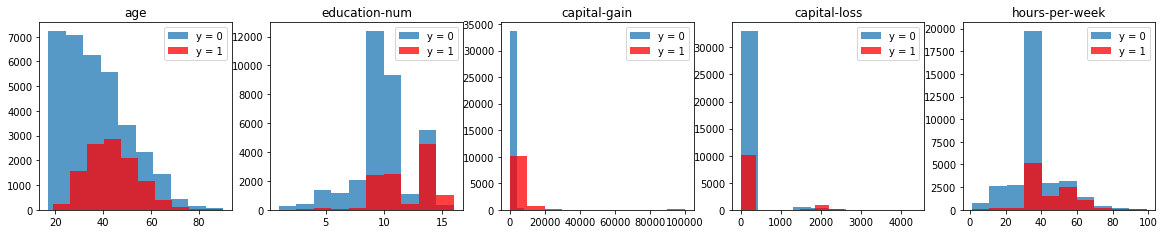

In [10]:
plt.figure(figsize = (20, 20))

idx_0 =  census['income'] == '<=50K'
idx_1 =  census['income'] == '>50K'

for i, feature in enumerate(census.select_dtypes(include = [np.number]).columns):
    plt.subplot(5, 5, i + 1)
    plt.hist(census.ix[idx_0, feature], normed = 0, alpha = 0.75, label = 'y = 0')
    plt.hist(census.ix[idx_1, feature], normed = 0, facecolor = 'red', alpha = 0.75, label = 'y = 1')
    plt.legend()
    plt.title(feature)

plt.show()

Dada la observación, se centra el estudio sobre las variables *capital-loss* y *capital-gain* ya que la mayoría de sus valores son 0.

In [11]:
census[(census['capital-gain'] == 0)].shape[0] / census.shape[0]

0.91619123435496

In [12]:
census[(census['capital-loss'] == 0)].shape[0] / census.shape[0]

0.9526779001371014

In [13]:
census[(census['capital-gain'] == 0) & (census['capital-loss'] == 0)].shape[0] / census.shape[0]

0.8688691344920614

Se observa como el 91% de las muestras de *capital-gain* son 0, como el 95% de las muestras de *capital-loss* y el 86% de las muestras tienen ambos valores a 0.

Por lo que se van a unir ambas columnas.

In [14]:
census['capital-gain-loss'] = census['capital-gain'] - census['capital-loss']
census = census.drop(['capital-gain', 'capital-loss'], axis = 1)

Finalizado el estudio de las variables númericas, se continua con el estudio de las variables categórica.

In [15]:
census = census.applymap(lambda x: x.strip() if type(x) is str else x)

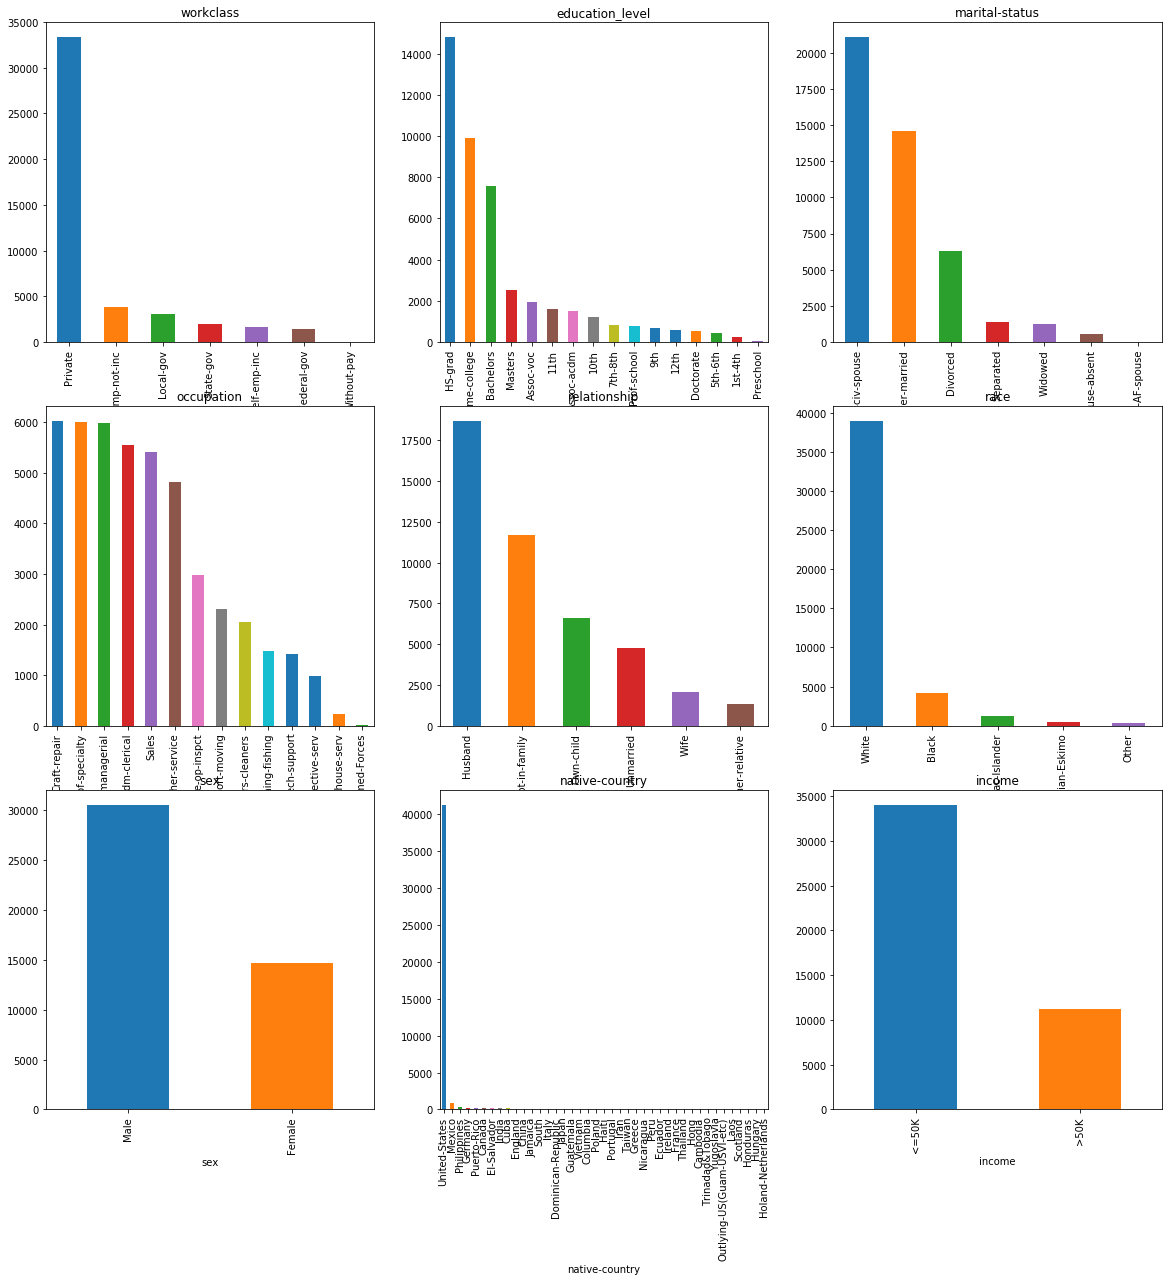

In [16]:
plt.figure(figsize = (20, 20))

for i, feature in enumerate(census.select_dtypes(include = [object]).columns):
    plt.subplot(3, 3, i + 1)
    census.groupby([feature]).size().sort_values(ascending = False).plot(kind = 'bar')
    plt.title(feature)

plt.show()

Dada la observación, se comprueba los valores que toman algunos de los valores categóricos.

In [17]:
cols = ['workclass', 'education_level', 'race', 'native-country']

for i in cols:
    print(census[i].value_counts())

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64
HS-grad         14783
Some-college     9899
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           823
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: education_level, dtype: int64
White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64
United-States                 41292
Mexico                          903
Philippines                     283
Germany                         193
Puerto-Rico                     175
Canada                          163
India              

Para la variable *workclass* se van a agrupar los trabajos *gov* y *self*.

In [18]:
census.loc[census.workclass.str.contains("gov"), 'workclass'] = 'Government'
census.loc[census.workclass.str.contains("Self"), 'workclass'] = 'Self'

Se observa que la variable *education-num* y *education_level* son la misma. A continuación se comprueba:

In [19]:
for i in range(1, 16):
    print('education-num:', i, '-> Valores:', census[(census['education-num'] == i)]['education_level'].unique())

education-num: 1 -> Valores: ['Preschool']
education-num: 2 -> Valores: ['1st-4th']
education-num: 3 -> Valores: ['5th-6th']
education-num: 4 -> Valores: ['7th-8th']
education-num: 5 -> Valores: ['9th']
education-num: 6 -> Valores: ['10th']
education-num: 7 -> Valores: ['11th']
education-num: 8 -> Valores: ['12th']
education-num: 9 -> Valores: ['HS-grad']
education-num: 10 -> Valores: ['Some-college']
education-num: 11 -> Valores: ['Assoc-voc']
education-num: 12 -> Valores: ['Assoc-acdm']
education-num: 13 -> Valores: ['Bachelors']
education-num: 14 -> Valores: ['Masters']
education-num: 15 -> Valores: ['Prof-school']


Se observa que los datos son los mismos por lo que se puede borrar *education_level*.

In [20]:
census = census.drop(['education_level'], axis = 1)

Por la falta de datos:
- Para la variable *race* se va a agrupar en *White* y *non-White*.
- Para la variable *native-country* se va a agrupar en *United-States* vs *non-United-States*.

In [21]:
census.loc[~census.race.str.contains("White"), 'race'] = 'non-White'

In [22]:
census.loc[~census['native-country'].str.contains("United-States"), 'native-country'] = 'non-United-States'

In [23]:
cols = list(census.columns.values)
cols.pop(cols.index('income'))
census = census[cols+['income']]
census.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital-gain-loss,income
0,39,Government,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,40.0,United-States,2174.0,<=50K
1,50,Self,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,13.0,United-States,0.0,<=50K
2,38,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,40.0,United-States,0.0,<=50K
3,53,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,non-White,Male,40.0,United-States,0.0,<=50K
4,28,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,non-White,Female,40.0,non-United-States,0.0,<=50K


Se finaliza codificando las variables categóricas.

In [24]:
le = LabelEncoder()
for c in census.select_dtypes(include = [object]).columns:
    if(census[c].nunique() == 2):
        census[c] = le.fit_transform(census[c])

census.head(10)

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital-gain-loss,income
0,39,Government,13.0,Never-married,Adm-clerical,Not-in-family,0,1,40.0,0,2174.0,0
1,50,Self,13.0,Married-civ-spouse,Exec-managerial,Husband,0,1,13.0,0,0.0,0
2,38,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,0,1,40.0,0,0.0,0
3,53,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,1,1,40.0,0,0.0,0
4,28,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,1,0,40.0,1,0.0,0
5,37,Private,14.0,Married-civ-spouse,Exec-managerial,Wife,0,0,40.0,0,0.0,0
6,49,Private,5.0,Married-spouse-absent,Other-service,Not-in-family,1,0,16.0,1,0.0,0
7,52,Self,9.0,Married-civ-spouse,Exec-managerial,Husband,0,1,45.0,0,0.0,1
8,31,Private,14.0,Never-married,Prof-specialty,Not-in-family,0,0,50.0,0,14084.0,1
9,42,Private,13.0,Married-civ-spouse,Exec-managerial,Husband,0,1,40.0,0,5178.0,1


In [25]:
for c in census.select_dtypes(include = [object]).columns:
    dummy = pd.get_dummies(census[c])
    census = pd.concat([census, dummy], axis = 1).drop(c, axis = 1)

In [26]:
census.describe()

,age,education-num,race,sex,hours-per-week,native-country,capital-gain-loss,income,Government,Private,...,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,...,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,0.139733,0.675048,40.938017,0.086905,1012.834925,0.247844,0.142674,0.736522,...,0.021582,0.119588,0.031401,0.051214,0.412764,0.258768,0.029831,0.146522,0.105878,0.046239
std,13.217870,2.552881,0.346714,0.468362,12.007508,0.281698,7530.315380,0.431766,0.349744,0.440524,...,0.145317,0.324483,0.174400,0.220436,0.492336,0.437963,0.170122,0.353632,0.307684,0.210004
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-4356.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,10.000000,0.000000,1.000000,40.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,13.000000,0.000000,1.000000,45.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,16.000000,1.000000,1.000000,99.000000,1.000000,99999.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Correlación entre variables

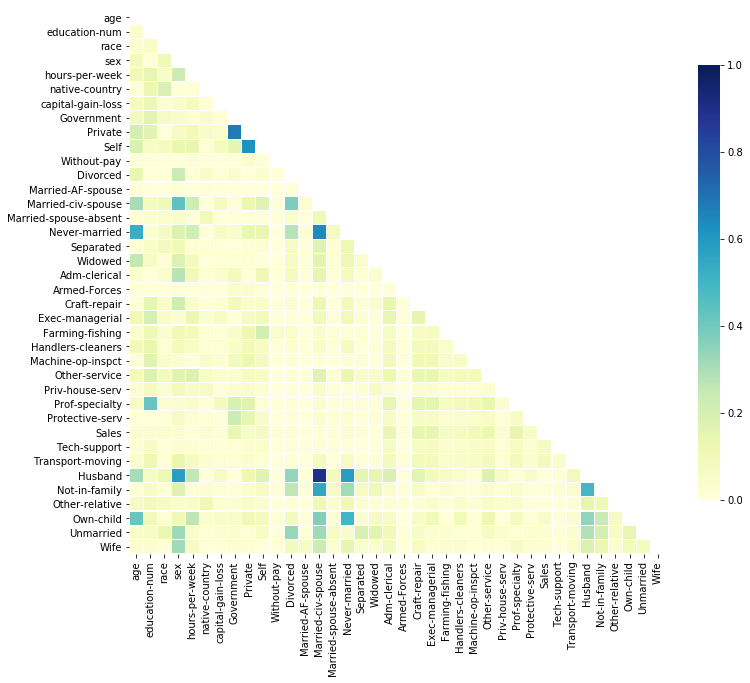

In [27]:
corr = np.abs(census.drop(['income'], axis = 1).corr())

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (12, 10))

sns.heatmap(corr, mask = mask, vmin = 0.0, vmax = 1.0, center = 0.5,
            linewidths = .1, cmap = "YlGnBu", cbar_kws = {"shrink": .8})

plt.show()

In [28]:
#pd.plotting.scatter_matrix(census, alpha = 0.2, figsize = (20, 20), diagonal = 'kde')
#plt.show()

Se observa que existen cierta correlación entre las variables originales *marital-status* y *relationship*, lo cual tiene sentido. En principio se podría eliminar la variable *Married-civ-spouse* pero por ser solo una de varias opciones se opta por no eliminar ninguna variable.

### División y escalado de datos

A continuación, se crean los datasets de train y test en una proporción 70% / 30% y se opta por utilizar *stratify* para que ambos datasets tengan la misma proporción de la variable *income*.

In [29]:
X1 = census.drop(['income'], axis = 1)
y1 = census['income']

feature_names = X1.columns

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, stratify = y1, random_state = 0)

In [30]:
scaler = StandardScaler().fit(X1_train)
X1s_train = scaler.transform(X1_train)
X1s_test  = scaler.transform(X1_test)

print('Datos train:', X1s_train.shape)
print('Datos test: ', X1s_test.shape)

print('Proporcion train: %0.3f'%np.mean(y1_train))
print('Proporcion test:  %0.3f'%np.mean(y1_test))

Datos train: (31655, 38)
Datos test:  (13567, 38)
Proporcion train: 0.248
Proporcion test:  0.248


### KNN

best mean cross-validation score: 0.831
best parameters: {'n_neighbors': 20}


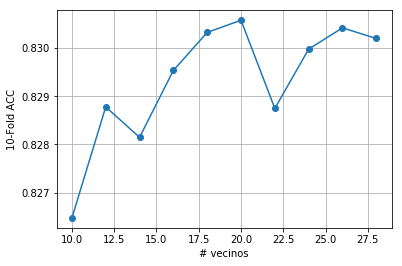

acc (test): 0.83


In [31]:
NVecinosIni = 10
NVecinosFin = 30
j = 2
nVecinos = range(NVecinosIni, NVecinosFin, j)

param_grid = {'n_neighbors':  np.arange(NVecinosIni, NVecinosFin, j)}

grid = GridSearchCV(KNeighborsClassifier(),
                    scoring = 'accuracy', param_grid = param_grid, cv = 10)

grid.fit(X1s_train, y1_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(nVecinos, scores,'-o')
plt.xlabel('# vecinos')
plt.ylabel('10-Fold ACC')
plt.grid()
plt.show()

print("acc (test): {:.2f}".format(grid.score(X1s_test, y1_test)))

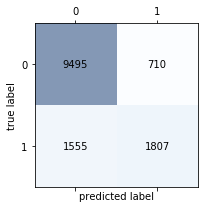

ACC:  0.8330507849929977
SEN:  0.5374776918500892
ESP:  0.9304262616364527
PPV:  0.7179181565355582
FSC:  0.6147303963259058


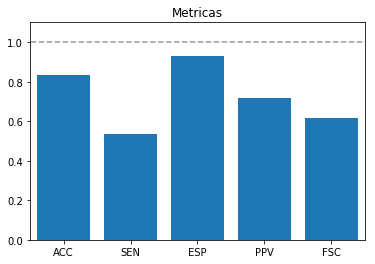

In [32]:
y1_pred = grid.predict(X1s_test)

confmat1_test = confusion_matrix(y1_test, y1_pred)
plot_confusion_matrix(confmat1_test)
calcula_metricas(confmat1_test)

Pese a obtener un buena exactitud (0.833), se observa que el algoritmo no se comparta bien con los falsos negativos. 

### Regresión logística

best mean cross-validation score: 0.800
best parameters: {'C': 20.6913808111479}


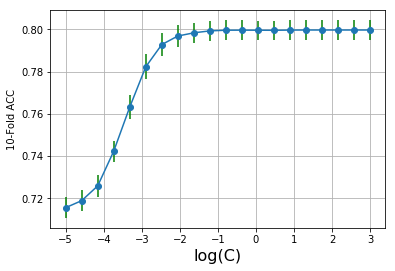

In [33]:
vectorC = np.logspace(-5, 3, 20)
param_grid = {'C': vectorC}

grid = GridSearchCV(LogisticRegression(random_state = 0, class_weight = 'balanced'),
                    scoring = 'accuracy',
                    param_grid = param_grid,
                    cv = 10)

grid.fit(X1s_train, y1_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC), scores, yerr = std_scores, fmt = 'o-', ecolor = 'g')
plt.xlabel('log(C)', fontsize = 16)
plt.ylabel('10-Fold ACC')
plt.grid()
plt.show()

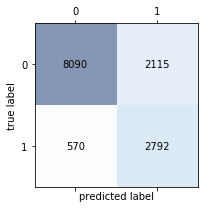

ACC:  0.8020933146605734
SEN:  0.8304580606781677
ESP:  0.792748652621264
PPV:  0.568983085388221
FSC:  0.6752932639980651


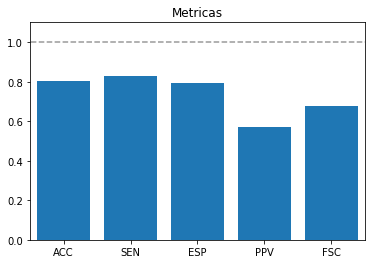

In [34]:
lr = LogisticRegression(random_state = 0, C = grid.best_params_['C'], class_weight = 'balanced').fit(X1s_train, y1_train)
y1_pred = lr.predict(X1s_test)

confmat1_test = confusion_matrix(y1_test, y1_pred)
plot_confusion_matrix(confmat1_test)
calcula_metricas(confmat1_test)

Se obtiene una exactitud algo peor que con el algoritmo KNN y los falsos positivos son demasiados.

### Filtrado de carácteristicas

Para poder continuar con el ejercicio se opta por reducir el número de características dado el alto coste computacional visto en los dos algoritmos anteriores. Además, de esta manera se obtiene una mejora interpretabilidad de los datos y se evita un posible sobreajuste en el estudio de los modelos.

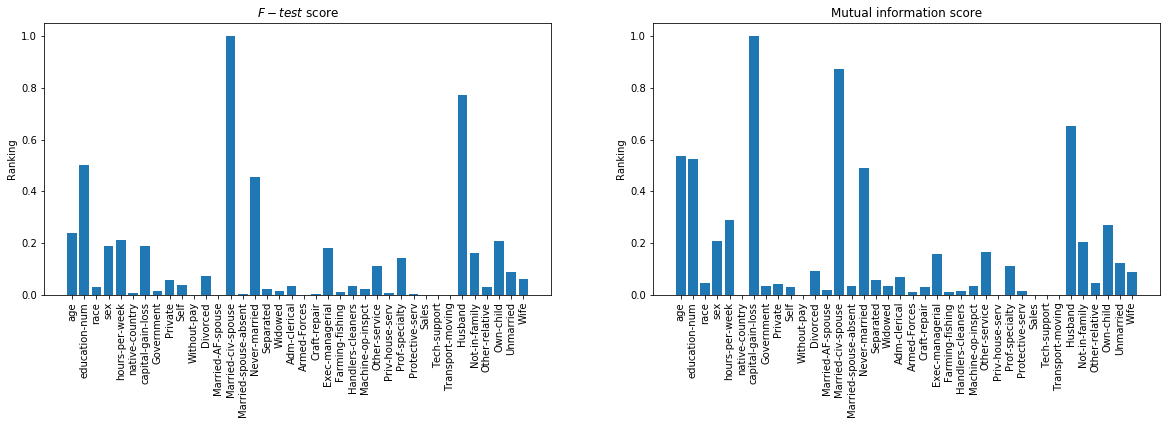

In [35]:
f_test, _ = f_classif(X1s_train, y1_train)
f_test /= np.max(f_test)

mi = mutual_info_classif(X1s_train, y1_train)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
plt.bar(range(X1s_train.shape[1]), f_test, align = "center")
plt.xticks(range(X1s_train.shape[1]), feature_names, rotation = 90)
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1, 2, 2)
plt.bar(range(X1s_train.shape[1]), mi, align = "center")
plt.xticks(range(X1s_train.shape[1]), feature_names, rotation = 90)
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

In [36]:
new_cols = feature_names[f_test > .05].tolist() + \
           list(set(feature_names[mi > .05].tolist()) - set(feature_names[f_test > .05].tolist()))

In [37]:
X1s_train_SF = X1_train[new_cols]
X1s_test_SF = X1_test[new_cols]

feature_names_SF = X1s_train_SF.columns

print('Nuevo Shape de train ', X1s_train_SF.shape)
print('Nuevo Shape de test', X1s_test_SF.shape)

scaler = StandardScaler().fit(X1s_train_SF)
X1s_train_SF = scaler.transform(X1s_train_SF)
X1s_test_SF = scaler.transform(X1s_test_SF)

Nuevo Shape de train  (31655, 19)
Nuevo Shape de test (13567, 19)


### Comparación clasificadores

A continuación, se va a realizar el estudio de diferentes modelos. Esta vez, además de utilizar el dataset con el filtrado de caractarísticas, se va utilizar el parámetro *scoring* igual a *f1* dado que estamos ante un problema desbalanceado y se ha observado un número alto de falsos positivos / negativos. Por ello la métrica a utilizar será FSC.

#### KNN

best mean cross-validation score: 0.612
best parameters: {'n_neighbors': 26}


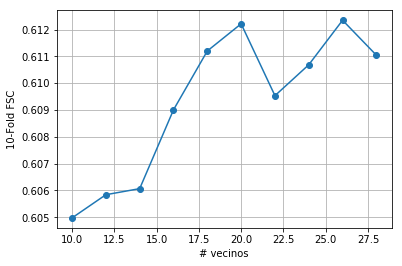

acc (test): 0.62


In [38]:
NVecinosIni = 10
NVecinosFin = 30
j = 2
nVecinos = range(NVecinosIni, NVecinosFin, j)

param_grid = {'n_neighbors':  np.arange(NVecinosIni, NVecinosFin, j)}

grid = GridSearchCV(KNeighborsClassifier(),
                    scoring = 'f1',
                    param_grid = param_grid,
                    cv = 10)

grid.fit(X1s_train_SF, y1_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(nVecinos, scores,'-o')
plt.xlabel('# vecinos')
plt.ylabel('10-Fold FSC')
plt.grid()
plt.show()

print("acc (test): {:.2f}".format(grid.score(X1s_test_SF, y1_test)))

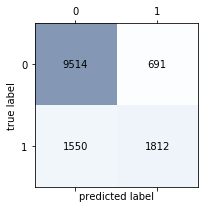

ACC:  0.8348197832977077
SEN:  0.5389649018441404
ESP:  0.9322880940715336
PPV:  0.7239312824610468
FSC:  0.6179028132992327


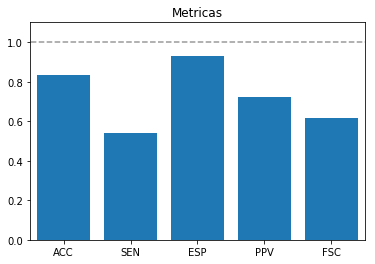

In [39]:
y1_pred = grid.predict(X1s_test_SF)

confmat1_test = confusion_matrix(y1_test, y1_pred)
plot_confusion_matrix(confmat1_test)
calcula_metricas(confmat1_test)

Se puede observar como se ha reducido el número de vecinos y ha mejorado muy poco el FSC. Además, se sigue observando un alto número de falsos negativos.

#### Regresión logística

best mean cross-validation score: 0.669
best parameters: {'C': 0.023357214690901212}


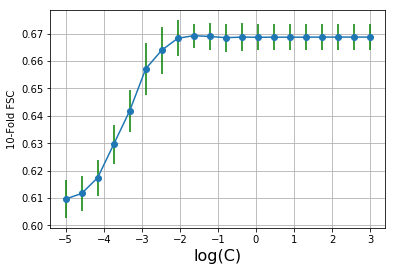

In [40]:
vectorC = np.logspace(-5, 3, 20)
param_grid = {'C': vectorC}

grid = GridSearchCV(LogisticRegression(random_state = 0, class_weight = 'balanced'),
                    scoring = 'f1',
                    param_grid = param_grid,
                    cv = 10)

grid.fit(X1s_train_SF, y1_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC), scores, yerr = std_scores, fmt = 'o-', ecolor = 'g')
plt.xlabel('log(C)', fontsize = 16)
plt.ylabel('10-Fold FSC')
plt.grid()
plt.show()

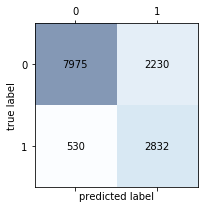

ACC:  0.7965651949583549
SEN:  0.842355740630577
ESP:  0.7814796668299853
PPV:  0.5594626629790597
FSC:  0.6723646723646722


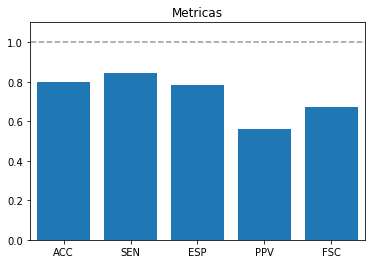

In [41]:
lr = LogisticRegression(random_state = 0,
                        C = grid.best_params_['C'],
                        class_weight = 'balanced').fit(X1s_train_SF, y1_train)
y1_pred = lr.predict(X1s_test_SF)

confmat1_test = confusion_matrix(y1_test, y1_pred)
plot_confusion_matrix(confmat1_test)
calcula_metricas(confmat1_test)

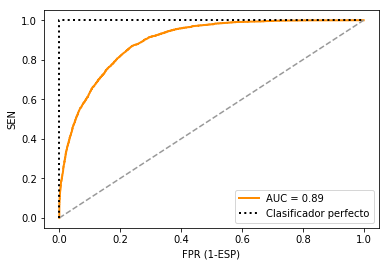

In [42]:
y1_prob = lr.predict_proba(X1s_test_SF)[:,1]

ejex, ejey, _ = roc_curve(y1_test, y1_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color = 'darkorange', lw = 2, label = 'AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color = (0.6, 0.6, 0.6), linestyle = '--')
plt.plot([0, 0, 1],[0, 1, 1], lw = 2, linestyle = ':', color = 'black', label = 'Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc = "lower right")
plt.show()

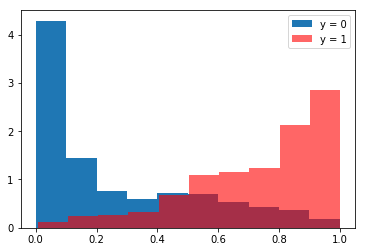

In [43]:
idx_0 = (y1_test == 0)
idx_1 = (y1_test == 1)

plt.hist(y1_prob[idx_0], normed = 1, label = 'y = 0')
plt.hist(y1_prob[idx_1], normed = 1, facecolor = 'r', alpha=0.6, label = 'y = 1')
plt.legend(loc = 1)
plt.show()

Aunque se obtiene una buena curva ROC se sigue obteniendo un número alto de falsos positivos. Además, el valor de FSC no ha mejorado.

#### Árboles de decisión

best mean cross-validation score: 0.683
best parameters: {'max_depth': 11}


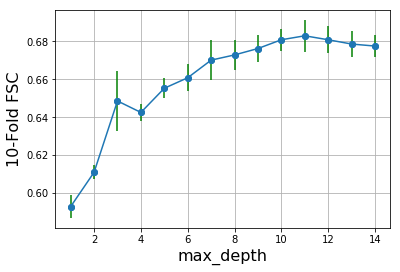

In [44]:
maxDepth = range(1, 15)
param_grid = {'max_depth': maxDepth }

grid = GridSearchCV(DecisionTreeClassifier(random_state = 0, class_weight = 'balanced'),
                    scoring = 'f1', 
                    param_grid = param_grid, 
                    cv = 10)

grid.fit(X1s_train_SF, y1_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.plot(maxDepth, scores, '-o')
plt.errorbar(maxDepth, scores, yerr = std_scores, fmt = 'o', ecolor = 'g')
plt.xlabel('max_depth', fontsize = 16)
plt.ylabel('10-Fold FSC', fontsize = 16)
plt.grid()
plt.show()

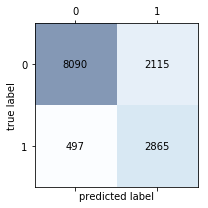

ACC:  0.8074740178373996
SEN:  0.8521713265913147
ESP:  0.792748652621264
PPV:  0.5753012048192772
FSC:  0.686885638935507


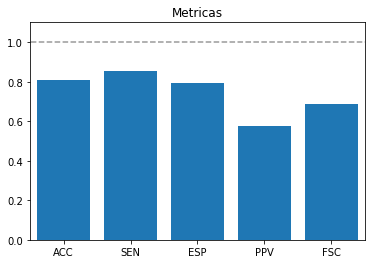

In [45]:
depthOpt = grid.best_params_['max_depth']

tree = DecisionTreeClassifier(random_state = 0,
                              max_depth = depthOpt,
                              class_weight = 'balanced').fit(X1s_train_SF, y1_train)
y1_pred = tree.predict(X1s_test_SF)

confmat1_test = confusion_matrix(y1_test, y1_pred)
plot_confusion_matrix(confmat1_test)
calcula_metricas(confmat1_test)

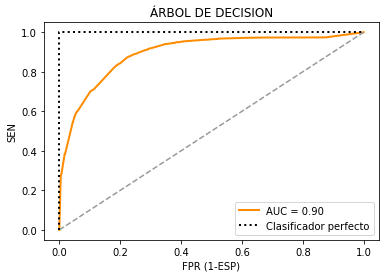

In [46]:
y1_prob = tree.predict_proba(X1s_test_SF)[:,1]

ejex, ejey, _ = roc_curve(y1_test, y1_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color = 'darkorange', lw = 2, label = 'AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color = (0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1], lw = 2, linestyle = ':', color = 'black', label = 'Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.title('ÁRBOL DE DECISION')
plt.legend(loc = "lower right")
plt.show()

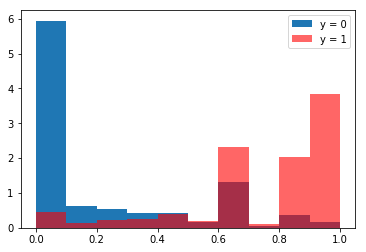

In [47]:
idx_0 = (y1_test == 0)
idx_1 = (y1_test == 1)

plt.hist(y1_prob[idx_0], normed = 1, label = 'y = 0')
plt.hist(y1_prob[idx_1], normed = 1, facecolor = 'r',alpha = 0.6, label = 'y = 1')
plt.legend(loc = 1)
plt.show()

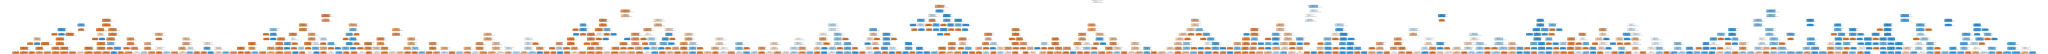

In [48]:
dot_data = export_graphviz(tree, out_file = None,
                         feature_names = feature_names_SF,
                         filled = True, rounded = True,
                         special_characters = True)
graph = graphviz.Source(dot_data) 

graph

Se obtiene un resultado ligeramente superior a los algoritmos anteriores pero se sigue observando un alto número de falsos positivos.

#### Random Forest

best mean cross-validation score: 0.698
best parameters: {'max_depth': 17}


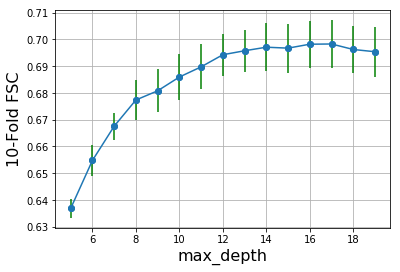

In [49]:
maxDepth   = range(5, 20)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state = 0, n_estimators = 200, max_features = 'sqrt', class_weight = 'balanced'),
                    scoring = 'f1', 
                    param_grid = param_grid, 
                    cv = 10,
                    n_jobs = -1)

grid.fit(X1s_train_SF, y1_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.plot(maxDepth, scores, '-o')
plt.errorbar(maxDepth, scores, yerr = std_scores, fmt = 'o', ecolor = 'g')
plt.xlabel('max_depth', fontsize = 16)
plt.ylabel('10-Fold FSC', fontsize = 16)
plt.grid()
plt.show()

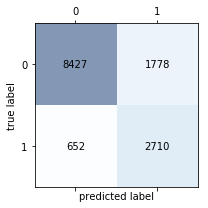

ACC:  0.8208889216481168
SEN:  0.8060678167757287
ESP:  0.8257716805487506
PPV:  0.6038324420677362
FSC:  0.6904458598726115


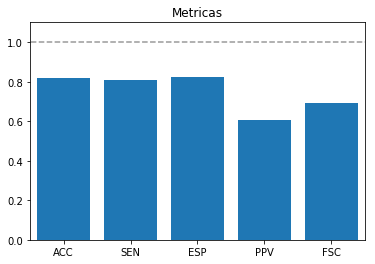

In [50]:
depthOpt = grid.best_params_['max_depth']

rf = RandomForestClassifier(random_state = 0,
                            max_depth = depthOpt,
                            n_estimators = 200,
                            class_weight = 'balanced',
                            max_features = 'sqrt').fit(X1s_train_SF, y1_train)
y1_pred_test = rf.predict(X1s_test_SF)

confmat1_test = confusion_matrix(y1_test, y1_pred_test)
plot_confusion_matrix(confmat1_test)
calcula_metricas(confmat1_test)

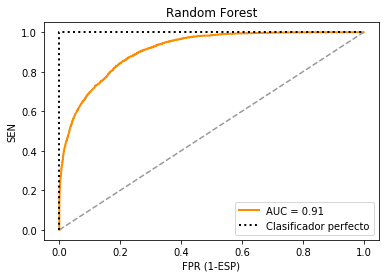

In [51]:
y1_prob = rf.predict_proba(X1s_test_SF)[:,1]

ejex, ejey, _ = roc_curve(y1_test, y1_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color = 'darkorange', lw = 2, label = 'AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color = (0.6, 0.6, 0.6), linestyle = '--')
plt.plot([0, 0, 1], [0, 1, 1], lw = 2, linestyle = ':',color = 'black', label = 'Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.title('Random Forest')
plt.legend(loc="lower right")
plt.show()

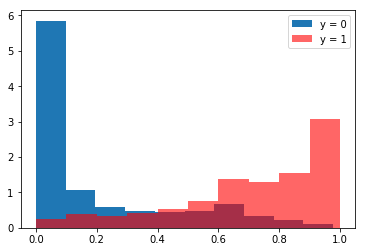

In [52]:
idx_0 = (y1_test == 0)
idx_1 = (y1_test == 1)

plt.hist(y1_prob[idx_0], normed = 1, label = 'y = 0')
plt.hist(y1_prob[idx_1], normed = 1, facecolor = 'r', alpha=0.6, label = 'y = 1')
plt.legend(loc = 1)
plt.show()

Se obtiene un resultado ligeramente superior a los algoritmos anteriores pero se sigue observando un alto número de falsos positivos aunque menor que en los modelos anteriores.

#### Boosting Forest

In [53]:
Niterations = [25, 50, 75, 100, 125, 150, 175, 200, 300]
learningRate = [0.5, 0.1, 0.05, 0.01, 0.005]

param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate}
grid = GridSearchCV(GradientBoostingClassifier(random_state = 0, max_depth = 3),
                    scoring = 'f1', 
                    param_grid = param_grid,
                    cv = 5,
                    n_jobs = -1)

grid.fit(X1s_train_SF, y1_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.701
best parameters: {'learning_rate': 0.1, 'n_estimators': 300}


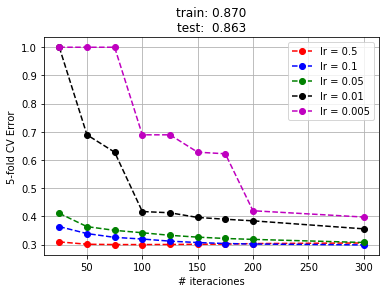

In [54]:
learningRateOpt = grid.best_params_['learning_rate']
nEstimatorsOpt = grid.best_params_['n_estimators']

bt = GradientBoostingClassifier(random_state = 0,
                                max_depth = 3,
                                learning_rate = learningRateOpt,
                                n_estimators = nEstimatorsOpt).fit(X1s_train_SF, y1_train)

error = 1 - grid.cv_results_['mean_test_score'].reshape(len(learningRate), len(Niterations))
colors = ['r', 'b', 'g', 'k', 'm']
for i, lr in enumerate(learningRate):
    plt.plot(Niterations, error[i,:], colors[i] + '--o', label = 'lr = %g' % lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X1s_train_SF, y1_train), bt.score(X1s_test_SF, y1_test)))
plt.grid()
plt.show()

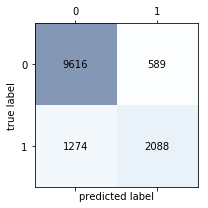

ACC:  0.8626815065968895
SEN:  0.6210588935157644
ESP:  0.9422831945124939
PPV:  0.7799775868509525
FSC:  0.69150521609538


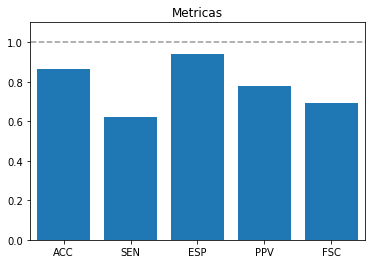

In [55]:
y1_pred = bt.fit(X1s_train_SF, y1_train).predict(X1s_test_SF)

confmat1_test = confusion_matrix(y1_test, y1_pred)
plot_confusion_matrix(confmat1_test)
calcula_metricas(confmat1_test)

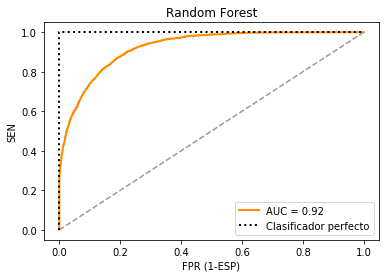

In [56]:
y1_prob = bt.predict_proba(X1s_test_SF)[:,1]

ejex, ejey, _ = roc_curve(y1_test, y1_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color = 'darkorange', lw = 2, label = 'AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color = (0.6, 0.6, 0.6), linestyle = '--')
plt.plot([0, 0, 1], [0, 1, 1], lw = 2, linestyle = ':',color = 'black', label = 'Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.title('Random Forest')
plt.legend(loc="lower right")
plt.show()

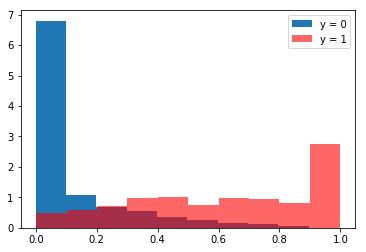

In [57]:
idx_0 = (y1_test == 0)
idx_1 = (y1_test == 1)

plt.hist(y1_prob[idx_0], normed = 1, label = 'y = 0')
plt.hist(y1_prob[idx_1], normed = 1, facecolor = 'r', alpha=0.6, label = 'y = 1')
plt.legend(loc = 1)
plt.show()

Se obtiene un resultado tanto en curva ROC como en el valor de FSC ligeramente superior a los anteriores modelos aunque se observa un número alto de falsos negativos.

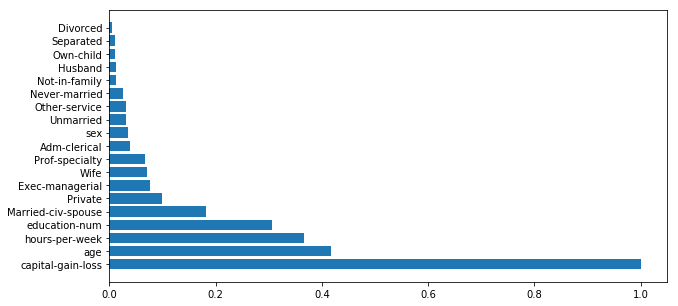

In [58]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize = (10, 5))
plt.barh(range(X1s_train_SF.shape[1]), importances[indices])
plt.yticks(range(X1s_train_SF.shape[1]), feature_names_SF[indices])
plt.show()

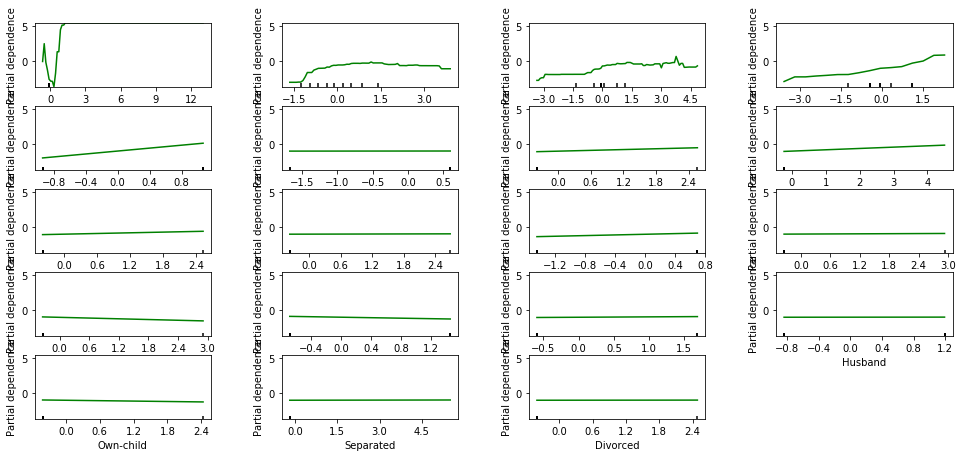

In [59]:
fig, ax = plot_partial_dependence(bt, X1s_train_SF, indices, feature_names = feature_names_SF,
                                  percentiles = (0.0, 1.0), n_cols = 4)
fig.set_size_inches(15, 10)
plt.show()

Se observa que las variables más importantes son: *capital-gain-loss*, *age*, *hours-per-week* y *education-num*.

Además, se observa que casi todas las variables o valores de las variables tienen cierta importancia salvo dos: *race* y *native-country*.

## Problema de regresión

Archivo: **diamond.csv**

El objetivo es estimar el precio (*price*) de un diamante a partir de un conjunto de propiedades físicas del mismo.

In [60]:
diamonds = pd.read_csv("./diamonds.csv", decimal='.')

### Análisis exploratorio

In [61]:
print("Dimensiones:", diamonds.shape)
diamonds.head(10)

Dimensiones: (53940, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


#### Preprocesamiento de variables

Se elimina la variable *Unnamed: 0* ya que no es necesaria.

In [62]:
diamonds = diamonds.drop(['Unnamed: 0'], axis = 1)

Se comprueba que no se tienen valores nulos.

In [63]:
diamonds.isnull().values.any()

False

Se comprueba los tipos de datos del dataset.

In [64]:
diamonds.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

A continuación, se realiza el estudio de las variables númericas.

In [65]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


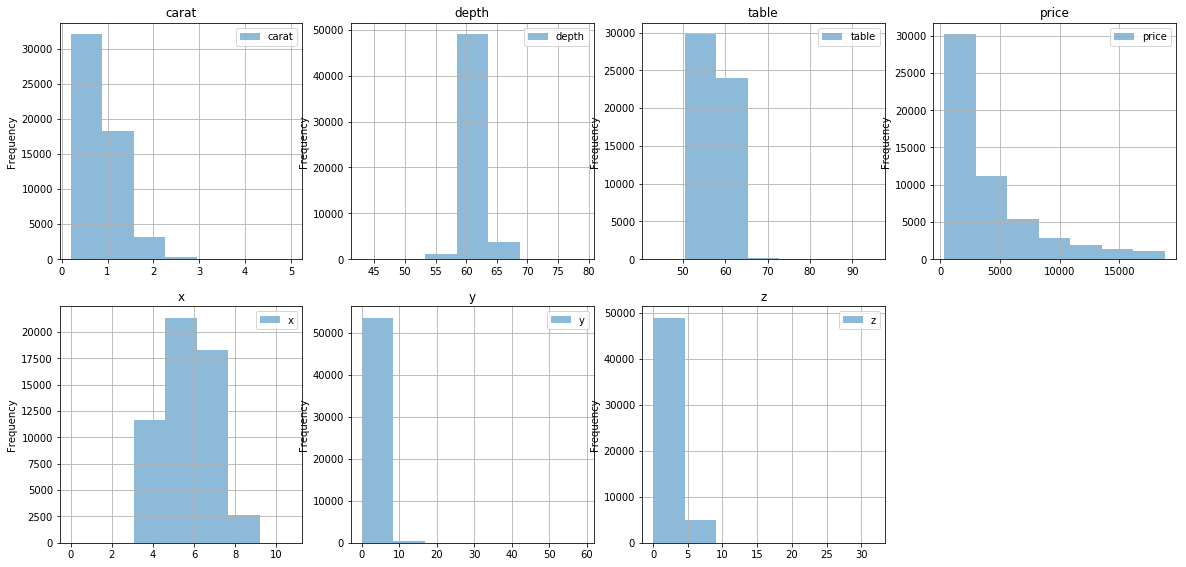

In [66]:
plt.figure(figsize = (20, 20))

for i, feature in enumerate(diamonds.select_dtypes(include = [np.number]).columns):
    plt.subplot(4, 4, i + 1)
    diamonds[feature].plot.hist(alpha = 0.5, bins = 7, grid = True)
    plt.legend()
    plt.title(feature)

plt.show()

Finalizado el estudio de las variables númericas, se continua con el estudio de las variables categóricas.

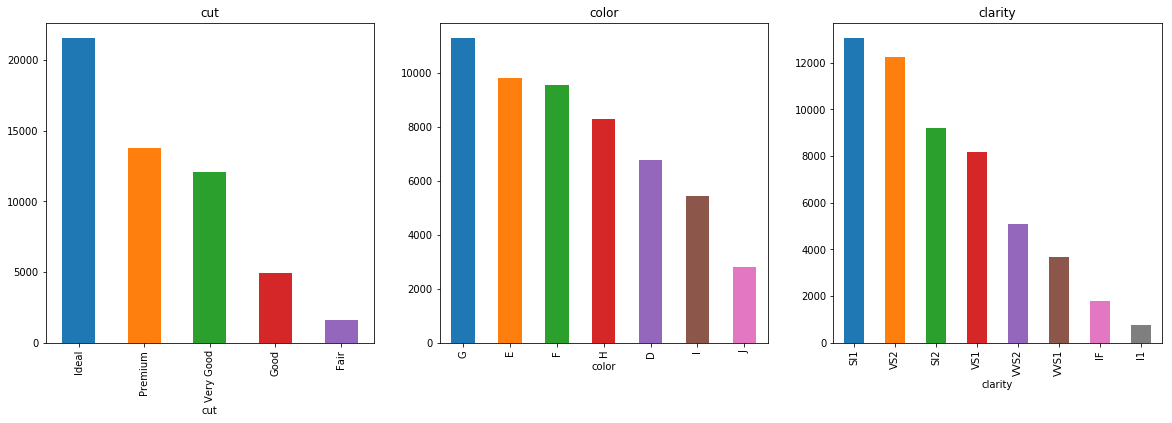

In [67]:
plt.figure(figsize = (20, 20))

for i, feature in enumerate(diamonds.select_dtypes(include = [object]).columns):
    plt.subplot(3, 3, i + 1)
    diamonds.groupby([feature]).size().sort_values(ascending = False).plot(kind = 'bar')
    plt.title(feature)

plt.show()

In [68]:
for i, feature in enumerate(diamonds.select_dtypes(include = [object]).columns):
    print(feature, "=>", diamonds[feature].unique())

cut => ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
color => ['E' 'I' 'J' 'H' 'F' 'G' 'D']
clarity => ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


Se finaliza codificando las variables categóricas según su mapeo asignado en el enunciado de la práctica.

In [69]:
diamonds['cut']     = diamonds['cut'].map({"Fair": 0, "Good": 1, "Very Good": 2,
                                           "Premium": 3, "Ideal": 4})
diamonds['color']   = diamonds['color'].map({"J": 0, "I": 1, "H": 2, "G": 3,
                                             "F": 4, "E": 5, "D": 6})
diamonds['clarity'] = diamonds['clarity'].map({"I1": 0, "SI2": 1, "SI1": 2, "VS2": 3,
                                               "VS1": 4, "VVS2": 5, "VVS1": 6, "IF": 7})
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75


#### Correlación entre variables

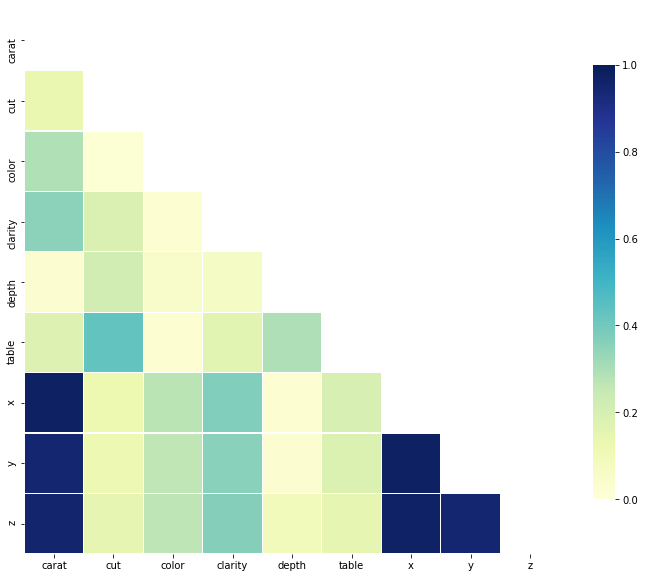

In [70]:
corr = np.abs(diamonds.drop(['price'], axis = 1).corr())

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (12, 10))

sns.heatmap(corr, mask = mask, vmin = 0.0, vmax = 1.0, center = 0.5,
            linewidths = .1, cmap = "YlGnBu", cbar_kws = {"shrink": .8})

plt.show()

Se observa que existe una alta correlación entre la variable *carat* y *x, y, z*, por lo que se eliman estas últimas.

In [71]:
diamonds = diamonds.drop(['x', 'y', 'z'], axis = 1)

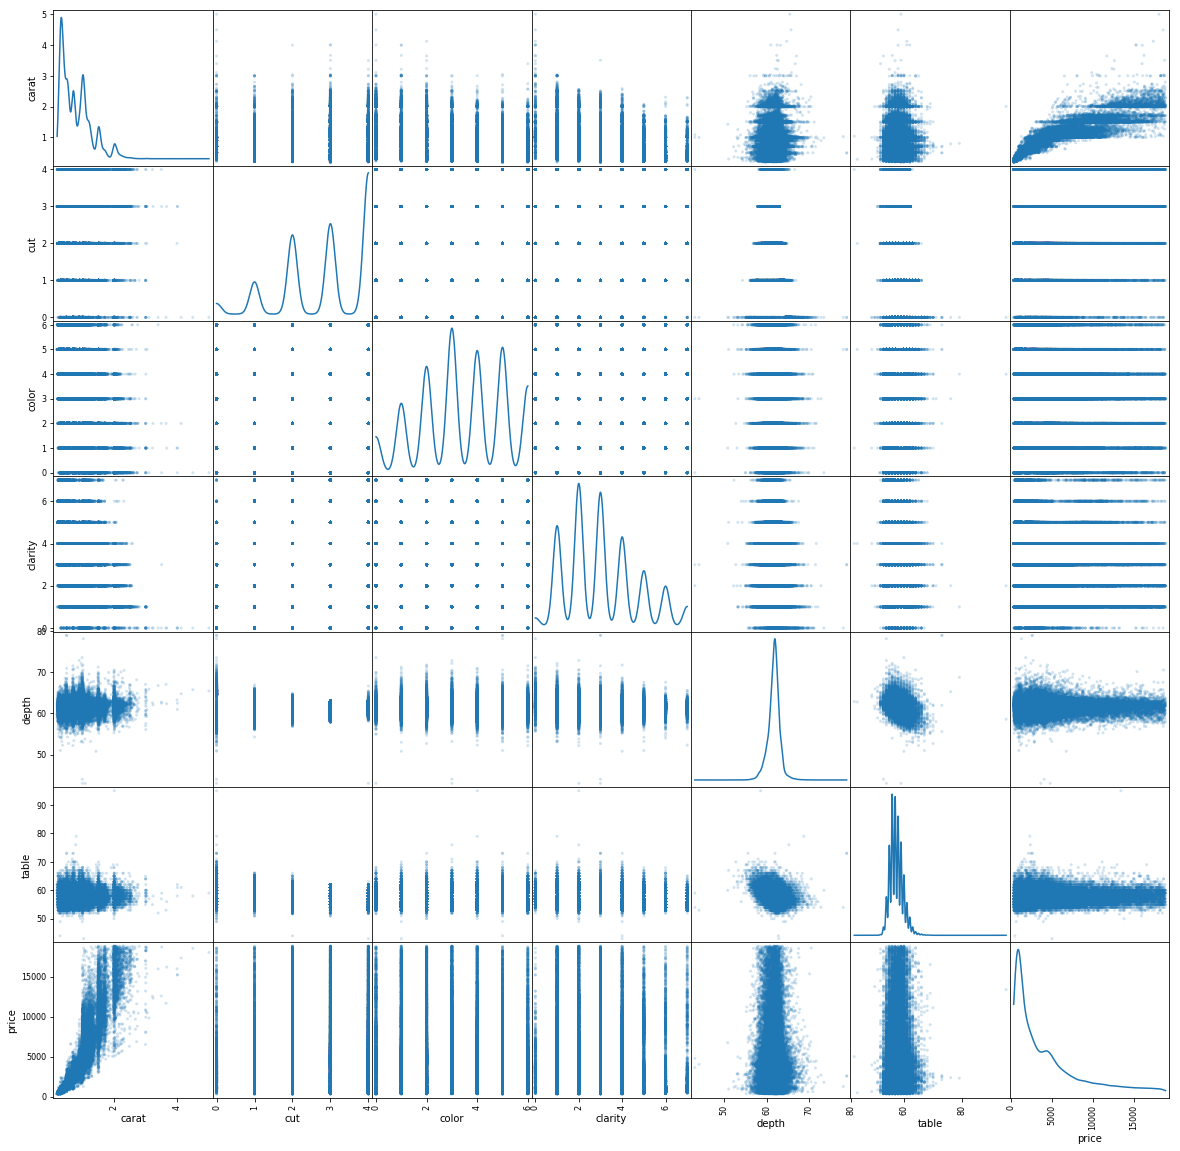

In [72]:
pd.plotting.scatter_matrix(diamonds, alpha = 0.2, figsize = (20, 20), diagonal = 'kde')
plt.show()

Se observa que la relación entre la variable *carat* y *price* tiene una forma exponencial, por lo que se opta por realizar una transformación logarítmica.

In [73]:
for feature in ['price','carat']:
    diamonds[feature] = np.log(diamonds[feature])

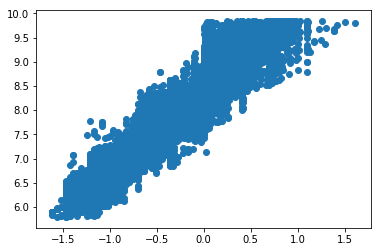

In [74]:
plt.scatter(diamonds['carat'], diamonds['price'])
plt.show()

Se puede ver como después de la transformación se obtiene una relación más lineal.

### División y escalado de datos

A continuación, se crean los datasets de train y test en una proporción 70% / 30%.

In [75]:
X2 = diamonds.drop(['price'], axis = 1)
y2 = diamonds['price']

feature_names = X2.columns

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, shuffle= True, random_state = 0)

In [76]:
scaler = StandardScaler().fit(X2_train)
X2s_train = scaler.transform(X2_train)
X2s_test  = scaler.transform(X2_test)

print('Datos train:', X2s_train.shape)
print('Datos test: ', X2s_test.shape)

print('Proporcion train: %0.3f'%np.mean(y2_train))
print('Proporcion test:  %0.3f'%np.mean(y2_test))

Datos train: (37758, 6)
Datos test:  (16182, 6)
Proporcion train: 7.787
Proporcion test:  7.785


### Comparación clasificadores

#### Regresión lineal

In [77]:
lr = LinearRegression()
lr.fit(X2s_train, y2_train)

y2_pred_train = lr.predict(X2s_train)
y2_pred_test = lr.predict(X2s_test)

mseTrainModelLR = mean_squared_error(y2_train, y2_pred_train)
mseTestModelLR = mean_squared_error(y2_test, y2_pred_test)

print('MSE Modelo Lineal Simple (train): %0.7g' % mseTrainModelLR)
print('MSE Modelo Lineal Simple (test) : %0.7g' % mseTestModelLR)
print("R^2 (train): {:.4f}".format(lr.score(X2s_train, y2_train)))
print("R^2 (test): {:.4f}".format(lr.score(X2s_test, y2_test)))

print('Coefficients:')
w = lr.coef_
for f, wi in zip(feature_names, w):
    print(f, wi)

MSE Modelo Lineal Simple (train): 0.02146707
MSE Modelo Lineal Simple (test) : 0.02113457
R^2 (train): 0.9791
R^2 (test): 0.9796
Coefficients:
carat 1.098370239308411
cut 0.0338882338681096
color 0.13141272009852334
clarity 0.2033128320079573
depth -0.005538950085484813
table -0.0014592852538238832


Se obtiene un gran resultado y, además como era de esperar, se observa una gran importancia entre la variable *carat* y *price* dado su relación lineal.

#### Ridge

best mean cross-validation score: -0.021
best parameters: {'alpha': 0.28117686979742307}


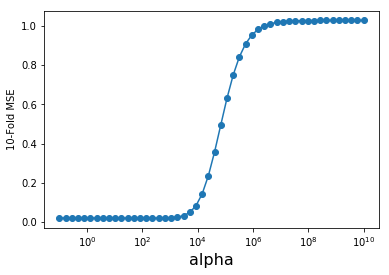

In [78]:
alpha_vector = np.logspace(-1, 10, 50)
param_grid = {'alpha': alpha_vector}

grid = GridSearchCV(Ridge(),
                    scoring = 'neg_mean_squared_error', param_grid = param_grid, cv = 10)
grid.fit(X2s_train, y2_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1 * np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector, scores, '-o')
plt.xlabel('alpha', fontsize = 16)
plt.ylabel('10-Fold MSE')
plt.show()

In [79]:
alpha_optimo = grid.best_params_['alpha']
ridge = Ridge(alpha = alpha_optimo).fit(X2s_train, y2_train)

ytrainRidge = ridge.predict(X2s_train)
ytestRidge  = ridge.predict(X2s_test)

mseTrainModelRidge = mean_squared_error(y2_train, ytrainRidge)
mseTestModelRidge = mean_squared_error(y2_test, ytestRidge)

print('MSE Modelo Ridge (train): %0.3g' % mseTrainModelRidge)
print('MSE Modelo Ridge (test) : %0.3g' % mseTestModelRidge)
print("R^2 (train): {:.4f}".format(ridge.score(X2s_train, y2_train)))
print("R^2 (test): {:.4f}".format(ridge.score(X2s_test, y2_test)))

w = ridge.coef_
for f, wi in zip(feature_names, w):
    print(f, wi)

MSE Modelo Ridge (train): 0.0215
MSE Modelo Ridge (test) : 0.0211
R^2 (train): 0.9791
R^2 (test): 0.9796
carat 1.0983583746834207
cut 0.0338879208378529
color 0.1314085674860297
clarity 0.20330682784211854
depth -0.00553887443837237
table -0.0014582288374423635


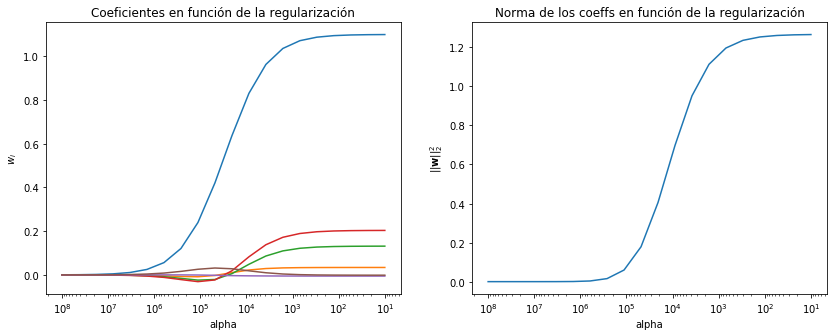

In [80]:
n_alphas = 20
alphas = np.logspace(1, 8, n_alphas)

coefs = []

norm2_coefs = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X2s_train, y2_train)
    coefs.append(ridge.coef_)
    norm2_coefs.append(np.dot(ridge.coef_,ridge.coef_.T))

plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()

Se obtiene un valor de *alpha* cercano a 0 por lo que no hay regularización y se obtiene el mismo resultado que en la regresión lineal original.

#### Lasso

best mean cross-validation score: -0.021
best parameters: {'alpha': 2.0235896477251556e-05}


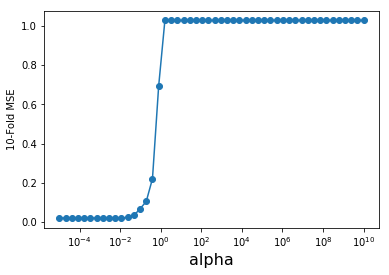

In [81]:
alpha_vector = np.logspace(-5, 10, 50)
param_grid = {'alpha': alpha_vector}

grid = GridSearchCV(Lasso(),
                    scoring = 'neg_mean_squared_error', param_grid = param_grid, cv = 10)
grid.fit(X2s_train, y2_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1 * np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector, scores, '-o')
plt.xlabel('alpha', fontsize = 16)
plt.ylabel('10-Fold MSE')
plt.show()

In [82]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X2s_train, y2_train)

ytrainLasso = lasso.predict(X2s_train)
ytestLasso  = lasso.predict(X2s_test)

mseTrainModelLasso = mean_squared_error(y2_train, ytrainLasso)
mseTestModelLasso = mean_squared_error(y2_test, ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)
print("R^2 (train): {:.4f}".format(lasso.score(X2s_train, y2_train)))
print("R^2 (test): {:.4f}".format(lasso.score(X2s_test, y2_test)))

w = lasso.coef_
for f, wi in zip(feature_names, w):
    print(f, wi)

MSE Modelo Lasso (train): 0.0215
MSE Modelo Lasso (test) : 0.0211
R^2 (train): 0.9791
R^2 (test): 0.9796
carat 1.098324438446015
cut 0.03388963579002686
color 0.13138243177886225
clarity 0.2032815682706304
depth -0.005510104144901096
table -0.001427198343900578


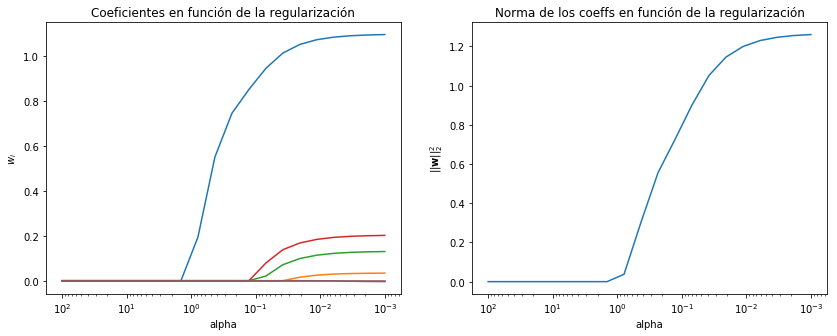

In [83]:
n_alphas = 20
alphas = np.logspace(-3, 2, n_alphas)

coefs = []

norm2_coefs = []
for a in alphas:
    ridge = Lasso(alpha=a)
    ridge.fit(X2s_train, y2_train)
    coefs.append(ridge.coef_)
    norm2_coefs.append(np.dot(ridge.coef_,ridge.coef_.T))

plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()

Se obtiene un valor de *alpha* cercano a 0 por lo que no hay regularización y se obtiene el mismo resultado que en la regresión lineal original.

#### Árboles de decisión

best mean cross-validation score: -0.013
best parameters: {'max_depth': 12}


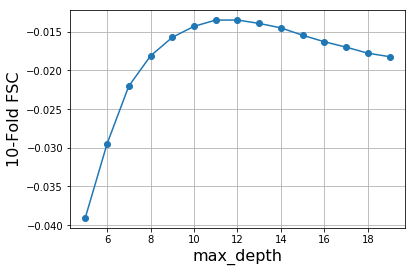

In [84]:
maxDepth = range(5, 20)
param_grid = {'max_depth': maxDepth }

grid = GridSearchCV(DecisionTreeRegressor(random_state = 0),
                    scoring = 'neg_mean_squared_error',
                    param_grid = param_grid,
                    cv = 10)

grid.fit(X2s_train, y2_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
plt.plot(maxDepth, scores, '-o')
plt.xlabel('max_depth', fontsize = 16)
plt.ylabel('10-Fold FSC', fontsize = 16)
plt.grid()
plt.show()

In [85]:
depthOpt = grid.best_params_['max_depth']

tree = DecisionTreeRegressor(random_state = 0,
                             max_depth = depthOpt).fit(X2s_train, y2_train)
ytrainDecisionTree = tree.predict(X2s_train)
ytestDecisionTree  = tree.predict(X2s_test)

mseTrainModelDecisionTree = mean_squared_error(y2_train, ytrainDecisionTree)
mseTestModelDecisionTree = mean_squared_error(y2_test, ytestDecisionTree)

print('MSE Modelo Decision Tree (train): %0.3g' % mseTrainModelDecisionTree)
print('MSE Modelo Decision Tree (test) : %0.3g' % mseTestModelDecisionTree)
print("R^2 (train): {:.4f}".format(tree.score(X2s_train, y2_train)))
print("R^2 (test): {:.4f}".format(tree.score(X2s_test, y2_test)))

MSE Modelo Decision Tree (train): 0.00822
MSE Modelo Decision Tree (test) : 0.0128
R^2 (train): 0.9920
R^2 (test): 0.9876


Se observa una diferencia entre los valors MSE de train y test por lo que se opta por un modelo simplificado.

In [86]:
tree = DecisionTreeRegressor(random_state = 0, max_depth = 10).fit(X2s_train, y2_train)
ytrainDecisionTree = tree.predict(X2s_train)
ytestDecisionTree  = tree.predict(X2s_test)

mseTrainModelDecisionTree = mean_squared_error(y2_train, ytrainDecisionTree)
mseTestModelDecisionTree = mean_squared_error(y2_test, ytestDecisionTree)

print('MSE Modelo Decision Tree (train): %0.3g' % mseTrainModelDecisionTree)
print('MSE Modelo Decision Tree (test) : %0.3g' % mseTestModelDecisionTree)
print("R^2 (train): {:.4f}".format(tree.score(X2s_train, y2_train)))
print("R^2 (test): {:.4f}".format(tree.score(X2s_test, y2_test)))

MSE Modelo Decision Tree (train): 0.0115
MSE Modelo Decision Tree (test) : 0.0138
R^2 (train): 0.9888
R^2 (test): 0.9867


Se obtiene un resultado ligeramente superior al de modelos anteriores.

#### Random Forest

best mean cross-validation score: -0.013
best parameters: {'max_depth': 14}


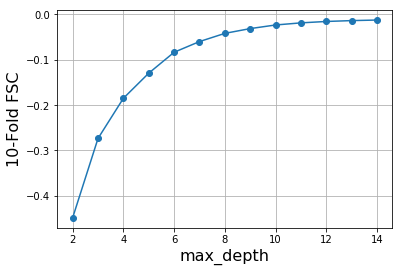

In [87]:
maxDepth   = range(2, 15)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state = 0, n_estimators = 200, max_features = 'sqrt'),
                    scoring = 'neg_mean_squared_error', 
                    param_grid = param_grid, 
                    cv = 10,
                    n_jobs = -1)

grid.fit(X2s_train, y2_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
plt.plot(maxDepth, scores, '-o')
plt.xlabel('max_depth', fontsize = 16)
plt.ylabel('10-Fold FSC', fontsize = 16)
plt.grid()
plt.show()

In [88]:
depthOpt = grid.best_params_['max_depth']

rf = RandomForestRegressor(random_state = 0,
                           max_depth = depthOpt,
                           n_estimators = 200,
                           max_features = 'sqrt').fit(X2s_train, y2_train)
ytrainRandomForest = rf.predict(X2s_train)
ytestRandomForest  = rf.predict(X2s_test)

mseTrainModelRandomForest = mean_squared_error(y2_train, ytrainRandomForest)
mseTestModelRandomForest = mean_squared_error(y2_test, ytestRandomForest)

print('MSE Modelo Random Forest (train): %0.3g' % mseTrainModelRandomForest)
print('MSE Modelo Random Forest (test) : %0.3g' % mseTestModelRandomForest)
print("R^2 (train): {:.4f}".format(rf.score(X2s_train, y2_train)))
print("R^2 (test): {:.4f}".format(rf.score(X2s_test, y2_test)))

MSE Modelo Random Forest (train): 0.0076
MSE Modelo Random Forest (test) : 0.0123
R^2 (train): 0.9926
R^2 (test): 0.9881


Se observa una diferencia entre los valors MSE de train y test por lo que se opta por un modelo simplificado.

In [89]:
rf = RandomForestRegressor(random_state = 0, max_depth = 10, n_estimators = 200, max_features = 'sqrt').fit(X2s_train, y2_train)
ytrainRandomForest = rf.predict(X2s_train)
ytestRandomForest  = rf.predict(X2s_test)

mseTrainModelRandomForest = mean_squared_error(y2_train, ytrainRandomForest)
mseTestModelRandomForest = mean_squared_error(y2_test, ytestRandomForest)

print('MSE Modelo Random Forest (train): %0.3g' % mseTrainModelRandomForest)
print('MSE Modelo Random Forest (test) : %0.3g' % mseTestModelRandomForest)
print("R^2 (train): {:.4f}".format(rf.score(X2s_train, y2_train)))
print("R^2 (test): {:.4f}".format(rf.score(X2s_test, y2_test)))

MSE Modelo Random Forest (train): 0.0207
MSE Modelo Random Forest (test) : 0.0227
R^2 (train): 0.9799
R^2 (test): 0.9781


No se ha conseguido mejorar el resultado obtenido por el anterior modelo.

#### Boosting Forest

In [90]:
Niterations = [25, 50, 75, 100, 125, 150, 175, 200, 300]
learningRate = [0.5, 0.1, 0.05, 0.01, 0.005]

param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate}
grid = GridSearchCV(GradientBoostingRegressor(random_state = 0, max_depth = 5),
                    scoring = 'neg_mean_squared_error', 
                    param_grid = param_grid,
                    cv = 5,
                    n_jobs = -1)

grid.fit(X2s_train, y2_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: -0.010
best parameters: {'learning_rate': 0.1, 'n_estimators': 300}


In [91]:
learningRateOpt = grid.best_params_['learning_rate']
nEstimatorsOpt = grid.best_params_['n_estimators']

bf = GradientBoostingRegressor(random_state = 0,
                               max_depth = 5,
                               learning_rate = learningRateOpt,
                               n_estimators = nEstimatorsOpt,
                               max_features = 'sqrt').fit(X2s_train, y2_train)
ytrainBoostingForest = bf.predict(X2s_train)
ytestBoostingForest  = bf.predict(X2s_test)

mseTrainModelBoostingForest = mean_squared_error(y2_train, ytrainBoostingForest)
mseTestModelBoostingForest = mean_squared_error(y2_test, ytestBoostingForest)

print('MSE Modelo Boosting Forest (train): %0.3g' % mseTrainModelBoostingForest)
print('MSE Modelo Boosting Forest (test) : %0.3g' % mseTestModelBoostingForest)
print("R^2 (train): {:.4f}".format(bf.score(X2s_train, y2_train)))
print("R^2 (test): {:.4f}".format(bf.score(X2s_test, y2_test)))

MSE Modelo Boosting Forest (train): 0.00943
MSE Modelo Boosting Forest (test) : 0.0103
R^2 (train): 0.9908
R^2 (test): 0.9901


Se consigue el mejor resultado de todos los modelos estudiados.

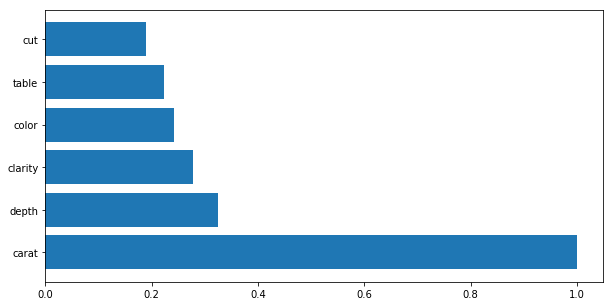

In [92]:
importances = bf.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize = (10, 5))
plt.barh(range(X2s_train.shape[1]), importances[indices])
plt.yticks(range(X2s_train.shape[1]), feature_names[indices])
plt.show()

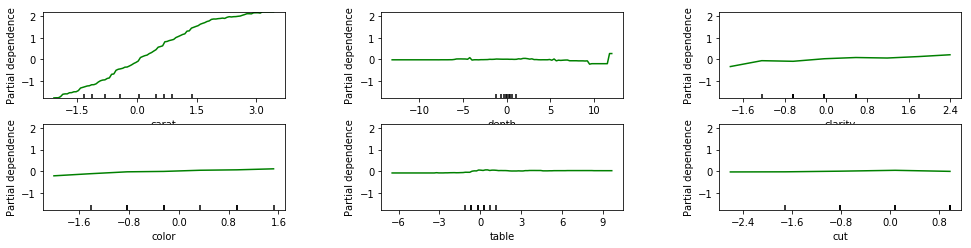

In [93]:
fig, ax = plot_partial_dependence(bf, X2s_train, indices, feature_names = feature_names,
                                  percentiles = (0.0, 1.0), n_cols = 3)
fig.set_size_inches(15, 5)
plt.show()

Se sigue observando como la variable *carat* es la más importante.